In [31]:
# Pip imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import stan

try:
    import arviz as az
except ImportError as err:
    print("Please, install arviz for easy visualization of Stan models.")

import nest_asyncio
nest_asyncio.apply()

import pandas as pd

print(stan.__version__)

3.10.0


In [ ]:
stan_code = """

data {
    int<lower=1> N;
    matrix[N, 3] x;
    vector[N] y;
}

parameters {
    real<lower=0> sigma;
    real alpha;
    vector[3] beta;
}

model {
    sigma ~ inv_gamma(0.1, 0.05);
    alpha ~ normal(0, 0.05);
    beta ~ normal(0, .1);

    for (n in 1:N) {
        y[n] ~ normal(alpha + beta' * (x[n]'), sigma);
    }
}

generated quantities{
  array[N] real pred_distr;
  for(i in 1:N){
    pred_distr[i] = normal_rng(alpha + beta' * (x[i]'), sigma);
  }
}

"""

Shape of Total Data Set: (1338,)
Split Row: 1204
Shape of Training Set: (1204,)
Shape of Test Set: (134,)


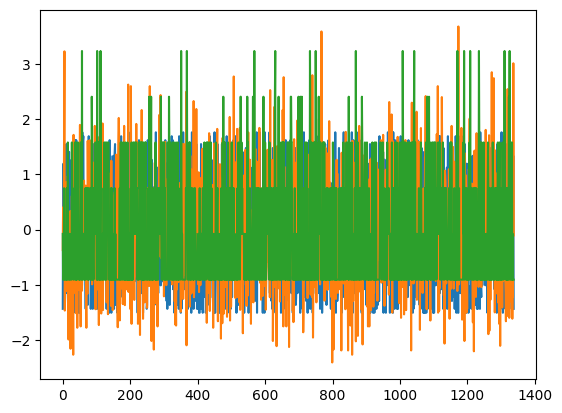

In [ ]:
# Read in the file
insurance_data = pd.read_csv("insurance.csv")

insurance_data = insurance_data.sample(frac=1).reset_index(drop=True)

key_param_df = insurance_data[['age', 'bmi', 'children']].astype(np.float64)

# Standardize the data in these columns

for col in key_param_df:
    key_param_df[col] = (key_param_df[col] - key_param_df[col].mean())/(key_param_df[col].std())

# Also standardize the charges
insurance_data["charges"] = (insurance_data['charges'] - insurance_data['charges'].mean())/(insurance_data['charges'].std())



parameter_vals = key_param_df.values
charges_vals = insurance_data["charges"].values

num_rows = parameter_vals.shape[0]

split_proportion = 0.1
split_row = int(num_rows * (1-split_proportion))

training_data_params = parameter_vals[:split_row, :]
testing_data_params = parameter_vals[split_row:, :]

training_data_charges = charges_vals[:split_row]
testing_data_charges = charges_vals[split_row:]

print(f"Shape of Total Data Set: {charges_vals.shape}")
print(f"Split Row: {split_row}")
print(f"Shape of Training Set: {training_data_charges.shape}")
print(f"Shape of Test Set: {testing_data_charges.shape}")



In [52]:

data_dict = {
    'N': training_data_charges.shape[0],
    # 'tau_0': 0.3,
    # 'tau_1': 0.6,
    # 'sigma_a': 5,
    # 'sigma_b': 1,
    #'x': np.ndarray(key_param_df.values, dtype=float)
    'x': training_data_params,
    'y': training_data_charges
}

model = stan.build(stan_code, data=data_dict)

Building...


Building: 64.1s, done.Messages from stanc:
Warning in '/tmp/httpstan_wc37mx1z/model_m3h3aubt.stan', line 38, column 21: Argument
    .1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_wc37mx1z/model_m3h3aubt.stan', line 37, column 22: Argument
    0.05 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_wc37mx1z/model_m3h3aubt.stan', line 36, column 27: Argument
    0.05 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_wc37mx1z/model_m3h3aubt.stan', line 36, column 22: Argument
    0.1 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).


In [53]:
fit = model.sample(num_chains=4, num_samples=2000, num_warmup=1000)

Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   0% (3/12000)
Sampling:   0% (4/12000)
Sampling:   1% (103/12000)
Sampling:   2% (202/12000)
Sampling:   3% (301/12000)
Sampling:   3% (400/12000)
Sampling:   4% (500/12000)
Sampling:   5% (600/12000)
Sampling:   6% (700/12000)
Sampling:   7% (800/12000)
Sampling:   8% (900/12000)
Sampling:   8% (1000/12000)
Sampling:   9% (1100/12000)
Sampling:  11% (1300/12000)
Sampling:  12% (1500/12000)
Sampling:  13% (1600/12000)
Sampling:  14% (1700/12000)
Sampling:  15% (1800/12000)
Sampling:  16% (1900/12000)
Sampling:  18% (2100/12000)
Sampling:  19% (2300/12000)
Sampling:  20% (2400/12000)
Sampling:  21% (2500/12000)
Sampling:  22% (2600/12000)
Sampling:  22% (2700/12000)
Sampling:  23% (2800/12000)
Sampling:  24% (2900/12000)
Sampling:  25% (3000/12000)
Sampling:  26% (3100/12000)
Sampling:  28% (3300/12000)
Sampling:  28% (3400/12000)
Sampling:  29% (3500/12000)
Sampling:  48% (5700/12000)
Sampling:  65% (7800/12000

In [54]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.944,0.019,0.908,0.979,0.000,0.000,9719.0,5765.0,1.0
alpha,0.006,0.024,-0.039,0.051,0.000,0.000,10057.0,6183.0,1.0
beta[0],0.260,0.026,0.211,0.311,0.000,0.000,9324.0,6531.0,1.0
beta[1],0.149,0.026,0.100,0.197,0.000,0.000,9350.0,6086.0,1.0
beta[2],0.056,0.026,0.006,0.105,0.000,0.000,9489.0,6339.0,1.0
...,...,...,...,...,...,...,...,...,...
pred_distr[1199],-0.241,0.952,-1.986,1.565,0.011,0.008,8033.0,7375.0,1.0
pred_distr[1200],-0.481,0.943,-2.295,1.280,0.010,0.008,8490.0,7682.0,1.0
pred_distr[1201],-0.486,0.949,-2.290,1.301,0.011,0.007,7994.0,7830.0,1.0
pred_distr[1202],0.242,0.941,-1.462,2.068,0.011,0.007,7459.0,7974.0,1.0


/home/krupkaa/anaconda3/envs/cognitive/lib/python3.12/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (1209), generating only 20 plots
  warnings.warn(


array([[<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'beta\n0'}>],
       [<Axes: title={'center': 'beta\n1'}>,
        <Axes: title={'center': 'beta\n1'}>],
       [<Axes: title={'center': 'beta\n2'}>,
        <Axes: title={'center': 'beta\n2'}>],
       [<Axes: title={'center': 'pred_distr\n0'}>,
        <Axes: title={'center': 'pred_distr\n0'}>],
       [<Axes: title={'center': 'pred_distr\n1'}>,
        <Axes: title={'center': 'pred_distr\n1'}>],
       [<Axes: title={'center': 'pred_distr\n2'}>,
        <Axes: title={'center': 'pred_distr\n2'}>],
       [<Axes: title={'center': 'pred_distr\n3'}>,
        <Axes: title={'center': 'pred_distr\n3'}>],
       [<Axes: title={'center': 'pred_distr\n4'}>,
        <Axes: title={'center': 'pred_distr\n4'}>],
       [<Axes: title={'center': 'pred_

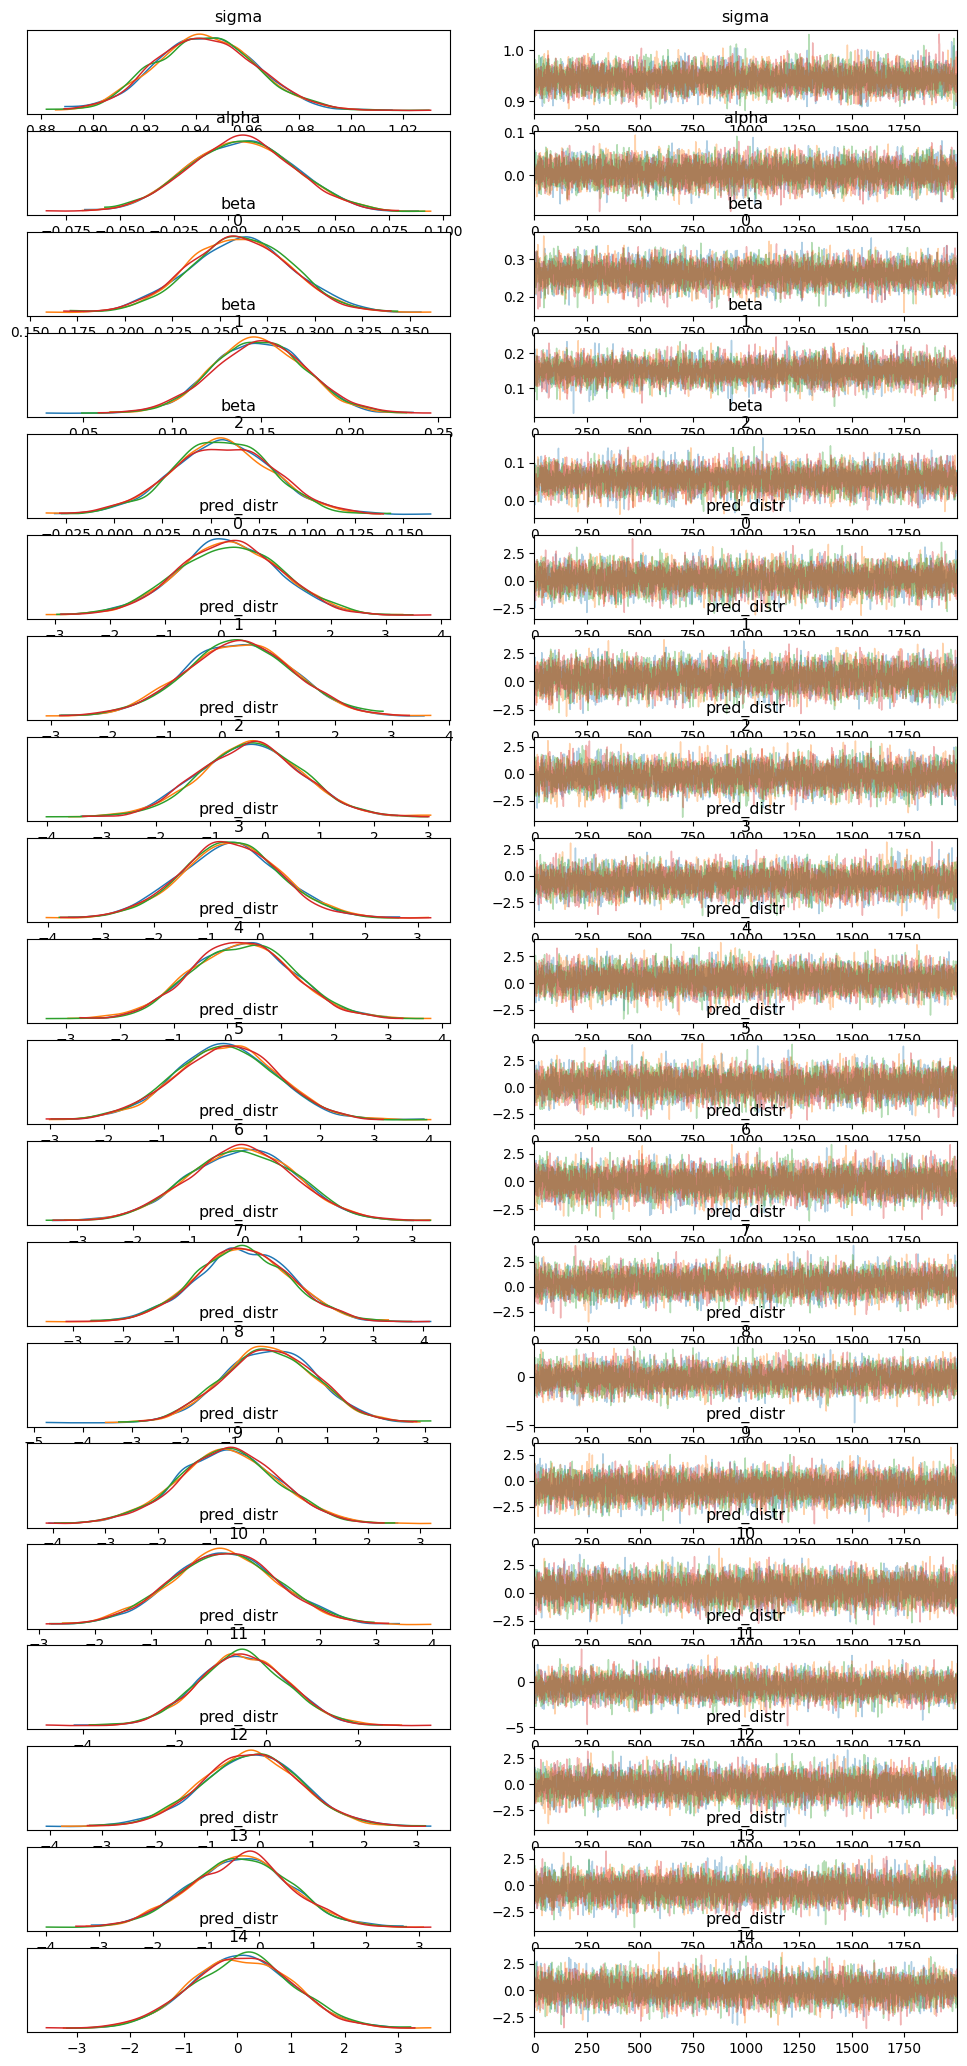

In [55]:
az.plot_trace(fit, compact=False, figsize=(12, 26))

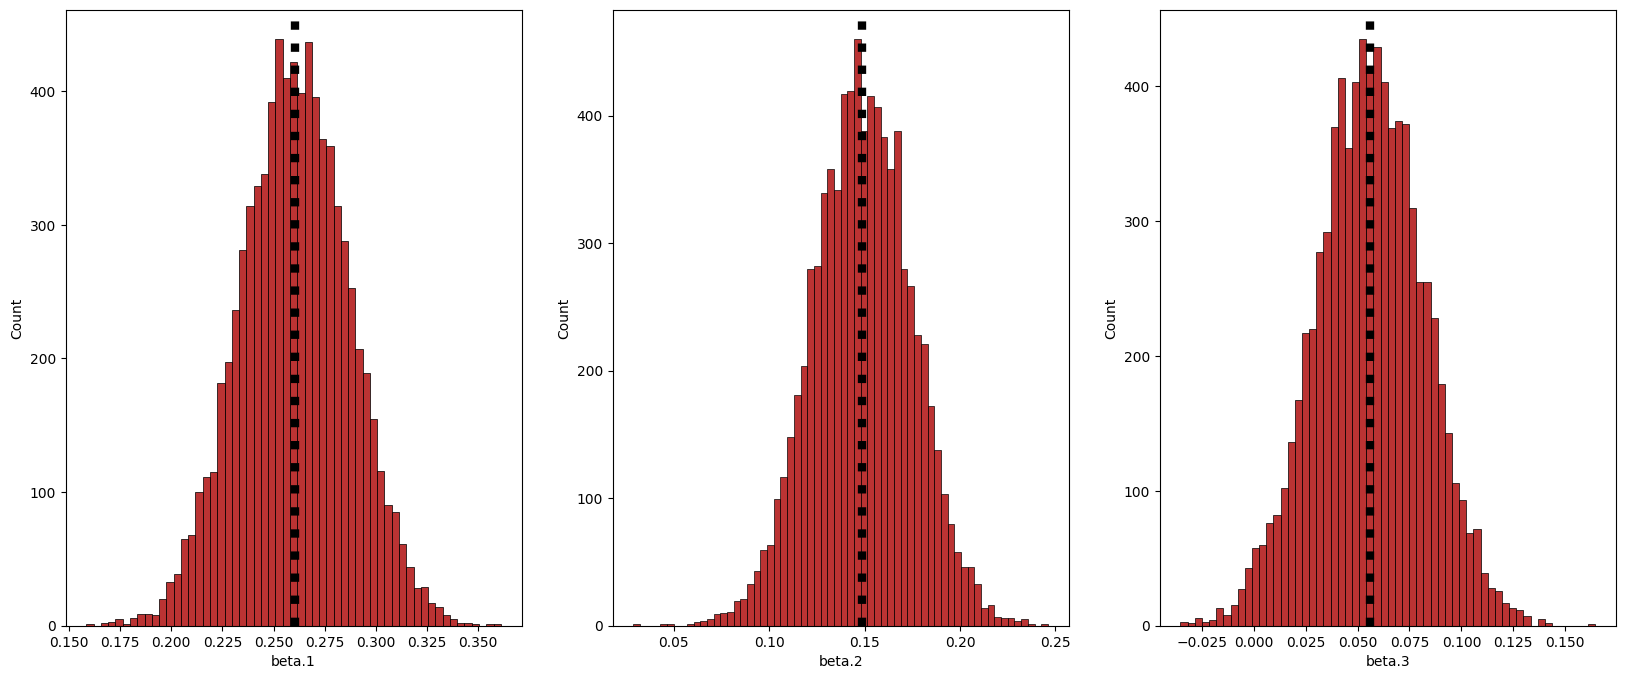

In [56]:
results_frame = fit.to_frame()

f, ax = plt.subplots(1, 3, figsize=(20, 8))

sns.histplot(results_frame, x='beta.1', ax = ax[0], color='#AA0000', alpha=0.8, lw=2)
sns.histplot(results_frame, x='beta.2', ax = ax[1], color='#AA0000', alpha=0.8, lw=2)
sns.histplot(results_frame, x='beta.3', ax = ax[2], color='#AA0000', alpha=0.8, lw=2)

ax[0].axvline(np.mean(results_frame['beta.1']), color='black', linestyle='dotted', lw=6)
ax[1].axvline(np.mean(results_frame['beta.2']), color='black', linestyle='dotted', lw=6)
ax[2].axvline(np.mean(results_frame['beta.3']), color='black', linestyle='dotted', lw=6)

### Problem 4

In [57]:
pred_distr = fit['pred_distr'] #Predictive distribution
num_samples = testing_data_charges.shape[0] #Nunmber of samples
pred_means = np.mean(pred_distr, axis=1) #Predictive distribution means
pred_samples = np.random.choice(pred_means, size=num_samples)

In [58]:
print (pred_samples.shape)
print (testing_data_charges.shape)

#Calculate the RMSE
rmse = np.sqrt((1/num_samples) * np.sum((pred_samples - testing_data_charges)**2))
print(f"RMSE = {rmse}")

(134,)
(134,)
RMSE = 0.9735139425581267
